# 결정트리, 랜덤 포레스트, 부스팅 - 회귀모델

## 문제: 기대수명 예측하기 (회귀)

- WHO가 제공하는 국가별 건강, 교육, 경제 데이터를 기반으로 기대 수명을 예측
- 193개국, 15년간 관측한 데이터 (2000~2015)로 20개의 특성 (feature) 사용
- 여러 특성간의 관계를 파악

## import 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from warnings import filterwarnings
filterwarnings('ignore')
%config InlineBackend.figure_format="retina"
matplotlib.rcParams['figure.figsize'] = (6,4)
matplotlib.rcParams.update({'font.size': 13})

In [2]:
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score               
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## 데이터

- Life Expectancy (WHO)
- 결측치가 많은 국가는 제외
- 데이터 (2938,22)

In [3]:
## 데이터 다운로드와 결측치 확인

data = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/Life%20Expectancy%20Data.csv")
print(data.shape)

# 결측치 확인
data.isnull().sum()

(2938, 22)


Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

- 결측치가 있는 샘플을 모두 삭제하겠다

In [4]:
## 결측치 처리와 카테고리 인코딩

# 결측치가 있는 샘플을 모두 삭제
df = data.dropna()

# 카테고리 변수 인코딩
print(df.Status.value_counts())
df.Status = df.Status.map({"Developing":0, "Developed":1})
print(df.shape)
df[:4].T

Developing    1407
Developed      242
Name: Status, dtype: int64
(1649, 22)


,0,1,2,3
Country,Afghanistan,Afghanistan,Afghanistan,Afghanistan
Year,2015,2014,2013,2012
Status,0,0,0,0
Life expectancy,65.0,59.9,59.9,59.5
Adult Mortality,263.0,271.0,268.0,272.0
infant deaths,62,64,66,69
Alcohol,0.01,0.01,0.01,0.01
percentage expenditure,71.279624,73.523582,73.219243,78.184215
Hepatitis B,65.0,62.0,64.0,67.0
Measles,1154,492,430,2787


# 데이터 탐색 

# 확률 분포

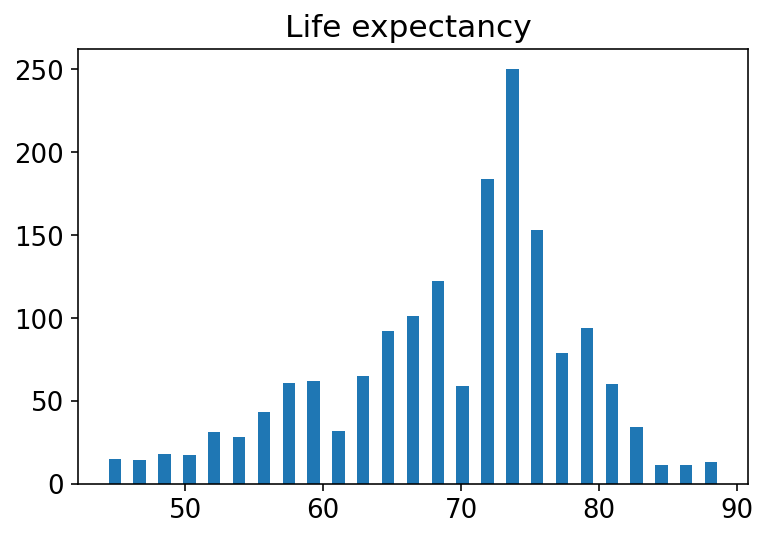

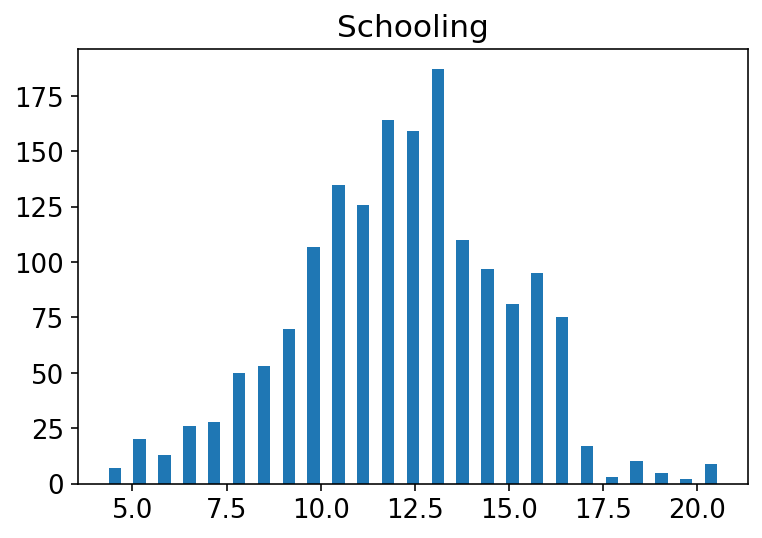

In [5]:
for col in ['Life expectancy ',"Schooling"]:
    plt.hist(df[col], bins=25, rwidth=0.5)
    plt.title(col)
    plt.show()

### 산포도

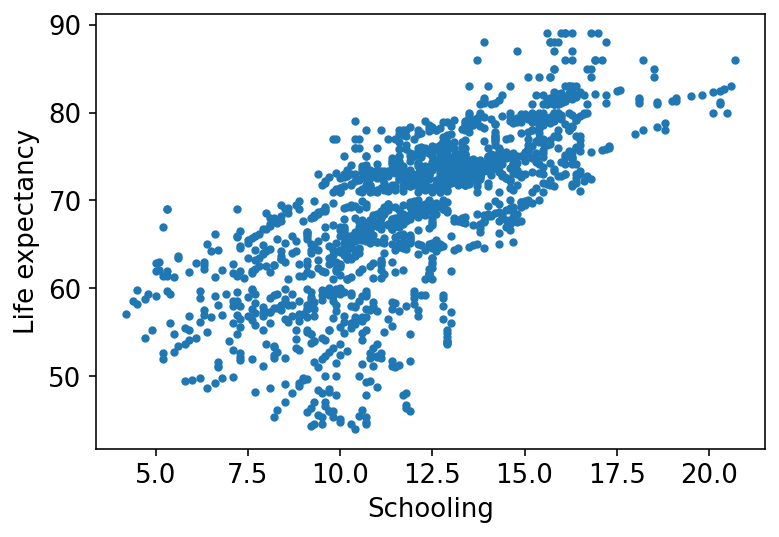

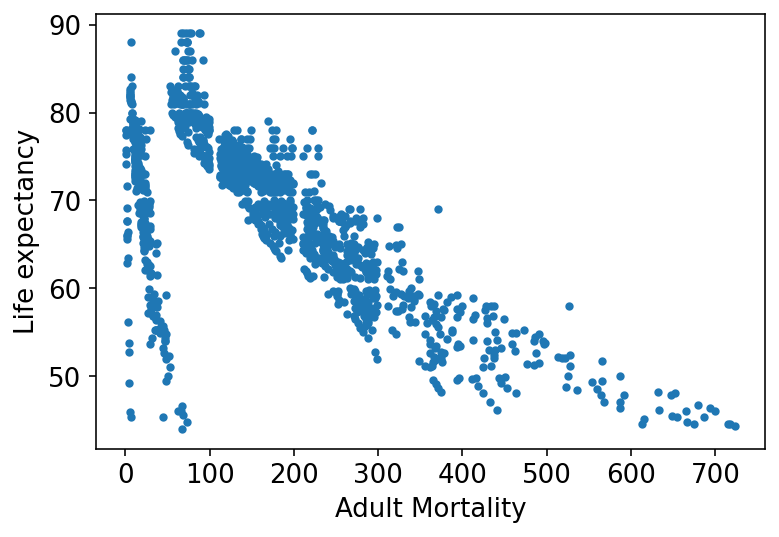

In [6]:
## 데이터 탐색 (산포도)

for col in ["Schooling", 'Adult Mortality']:
    plt.scatter(df[col] , df['Life expectancy '], s=10)
    plt.ylabel('Life expectancy')
    plt.xlabel(col)
    plt.show()

### 회귀 모델 성능 평가
- 회귀 모델의 성능을 평가하는 척도로 기본적으로 R-Squared를 사용하며 MAE, RMSE 등을 참고로 본다
 - MAE: mean absolute error  
 - MSE: mean squared error    
 - RMSE: root MSE  

$MAE = $$1\over{N}$$ \sum |y_{i} - \hat{y}|$

$MSE = $$1\over{N}$$ \sum (y_{i} - \hat{y})^{2}$

$RMSE = \sqrt{MSE}$

$R^{2} = 1$-$\sum(y_{i}-\hat{y})^{2}\over{\sum(y_{i}-\bar{y})^{2}}$ $= 1$-$MSE\over{Variance}$  
 >  $y$ :  실제값, $\hat{y}$ :  예측치, $\bar{y}$ :  평균치
 
-  R-Squared
 - 회귀 성능의 기본적인 평가 지표
 - MSE를 분산으로 정규화한 값을 사용한다
 - R-sqaured 값은 1에 가까울수록 완벽한 예측을 수행한 것이고, 0 근처이면 오차 평균치가 표준편차 정도인 경우이다

In [7]:
## 회귀 모델의 성능 평가 지표

# Maximum Error
# MAE: mean absolute error
# RMSE: root MSE
# R-Squared

def show_reg_result(y_test,y_pred):
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(3))

## 모든 변수를 사용 

- 다중 회귀 모델
 - 입력 변수가 2개인 다중회귀 모델이므로 파라미터가 변수의 수만큼 자동으로 2개 만들어진다
 - $\hat{y} = b +a_{1}x_{1} + a_{2}x_{2}$
 - $x_{1}$: 성별, $x_{2}$: 키

# 결과: 회귀결과 그래프

## 선형 계수

In [8]:
## 특성 중요도 보기

def plot_feature_weight(feature, weight):
    plt.figure(figsize=(5,8))
    W = pd.DataFrame({'feature':feature,'weight':weight})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

# 결정트리

- 결정 트리를 회귀모델에 사용할 때는 나누어지는 하위 두 그룹의 분산이 가능한 작아지도록 나눈다
 - 즉, 회귀 대상의 수치가 가능한 비슷한 샘플들이 모이도록 나눈다
- 결정 트리를 분류에 사용할 때는 크로스엔트로피 (또는 지니지수)가 가능한 작아지도록 나눈다
 - 즉, 나누어진 그룹에 같은 그룹의 샘플이 모이는 것을 측정하여 순도(purity)가 가능한 높아지도록 나눈다


In [9]:
## 훈련 데이터와 검증 데이터 준비

features = df.columns.difference(['Country','Life expectancy '])
X = df[features]
y = df["Life expectancy "]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9)

depth:  8 , R-squared:  0.9251


<AxesSubplot:xlabel='depth'>

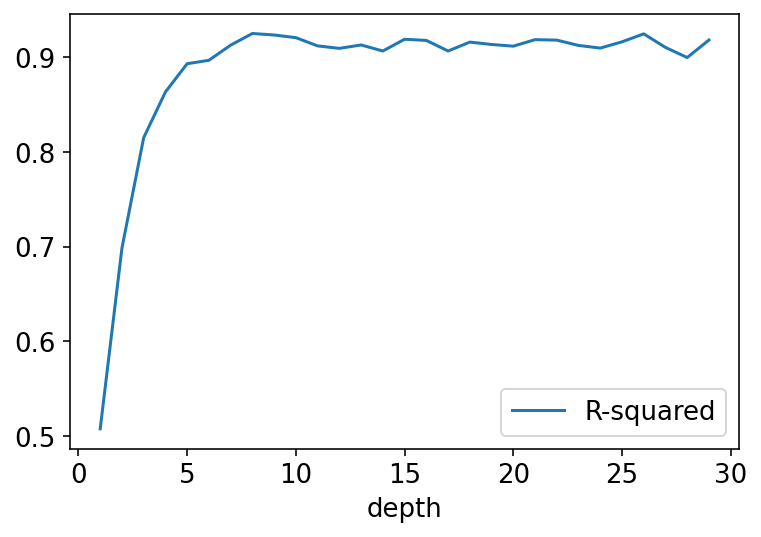

In [10]:
## 결정 트리를 이용한 회귀 예측

# 최적의 트리 깊이 (max_depth)를 실험으로 찾는다
res = []
for depth in range(1,30):
    dtr = DecisionTreeRegressor(max_depth=depth) 
    dtr.fit(X_train, y_train) 
    res.append((depth, dtr.score(X_test, y_test).round(4))) 

df_res = pd.DataFrame(res, columns=['depth','R-squared']).set_index('depth')
print('depth: ',df_res.idxmax()[0], ', R-squared: ',df_res.max()[0])
df_res.plot()

Max Error:  11.3
Mean Absolute Error:  1.69
Root Mean Squared Error:  2.599
R-Squared:  0.915


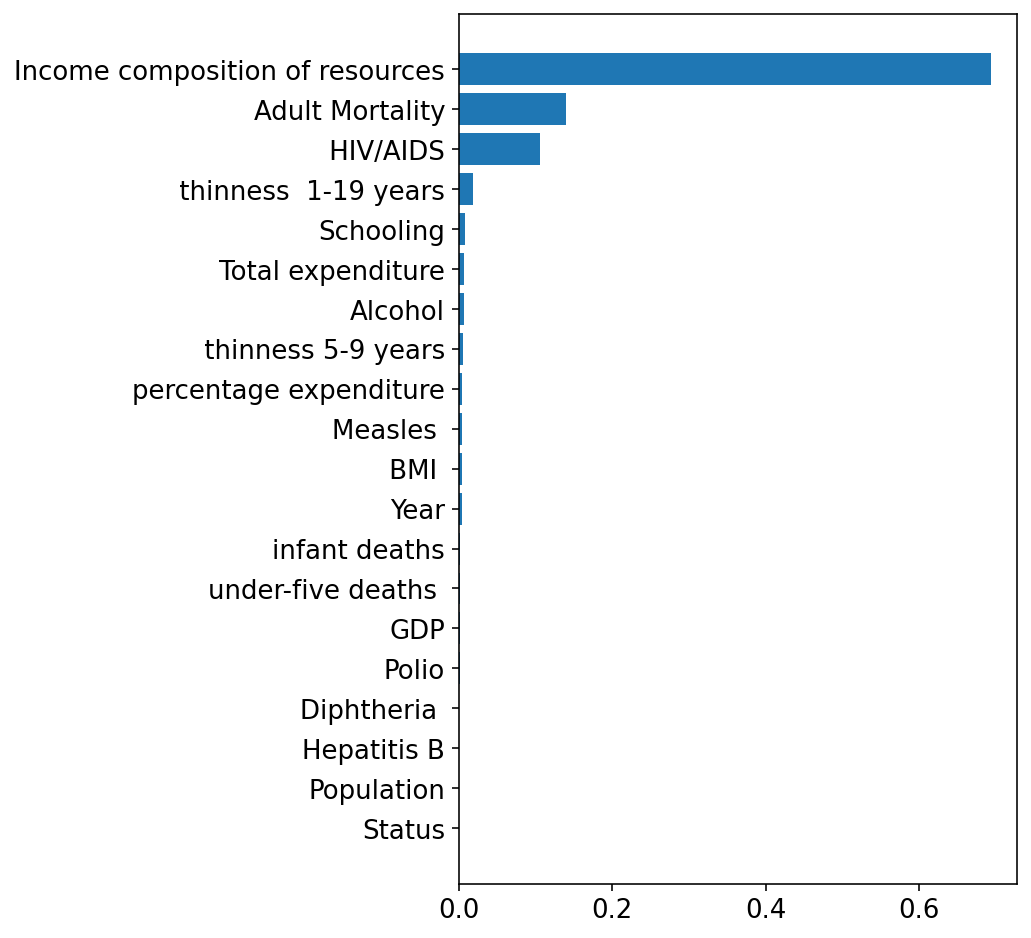

In [11]:
## 결정 트리 모델 성능 확인

dtr = DecisionTreeRegressor(max_depth=8)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)
show_reg_result(y_test,y_pred)

plot_feature_weight(X.columns, dtr.feature_importances_)

## 결정트리 보기

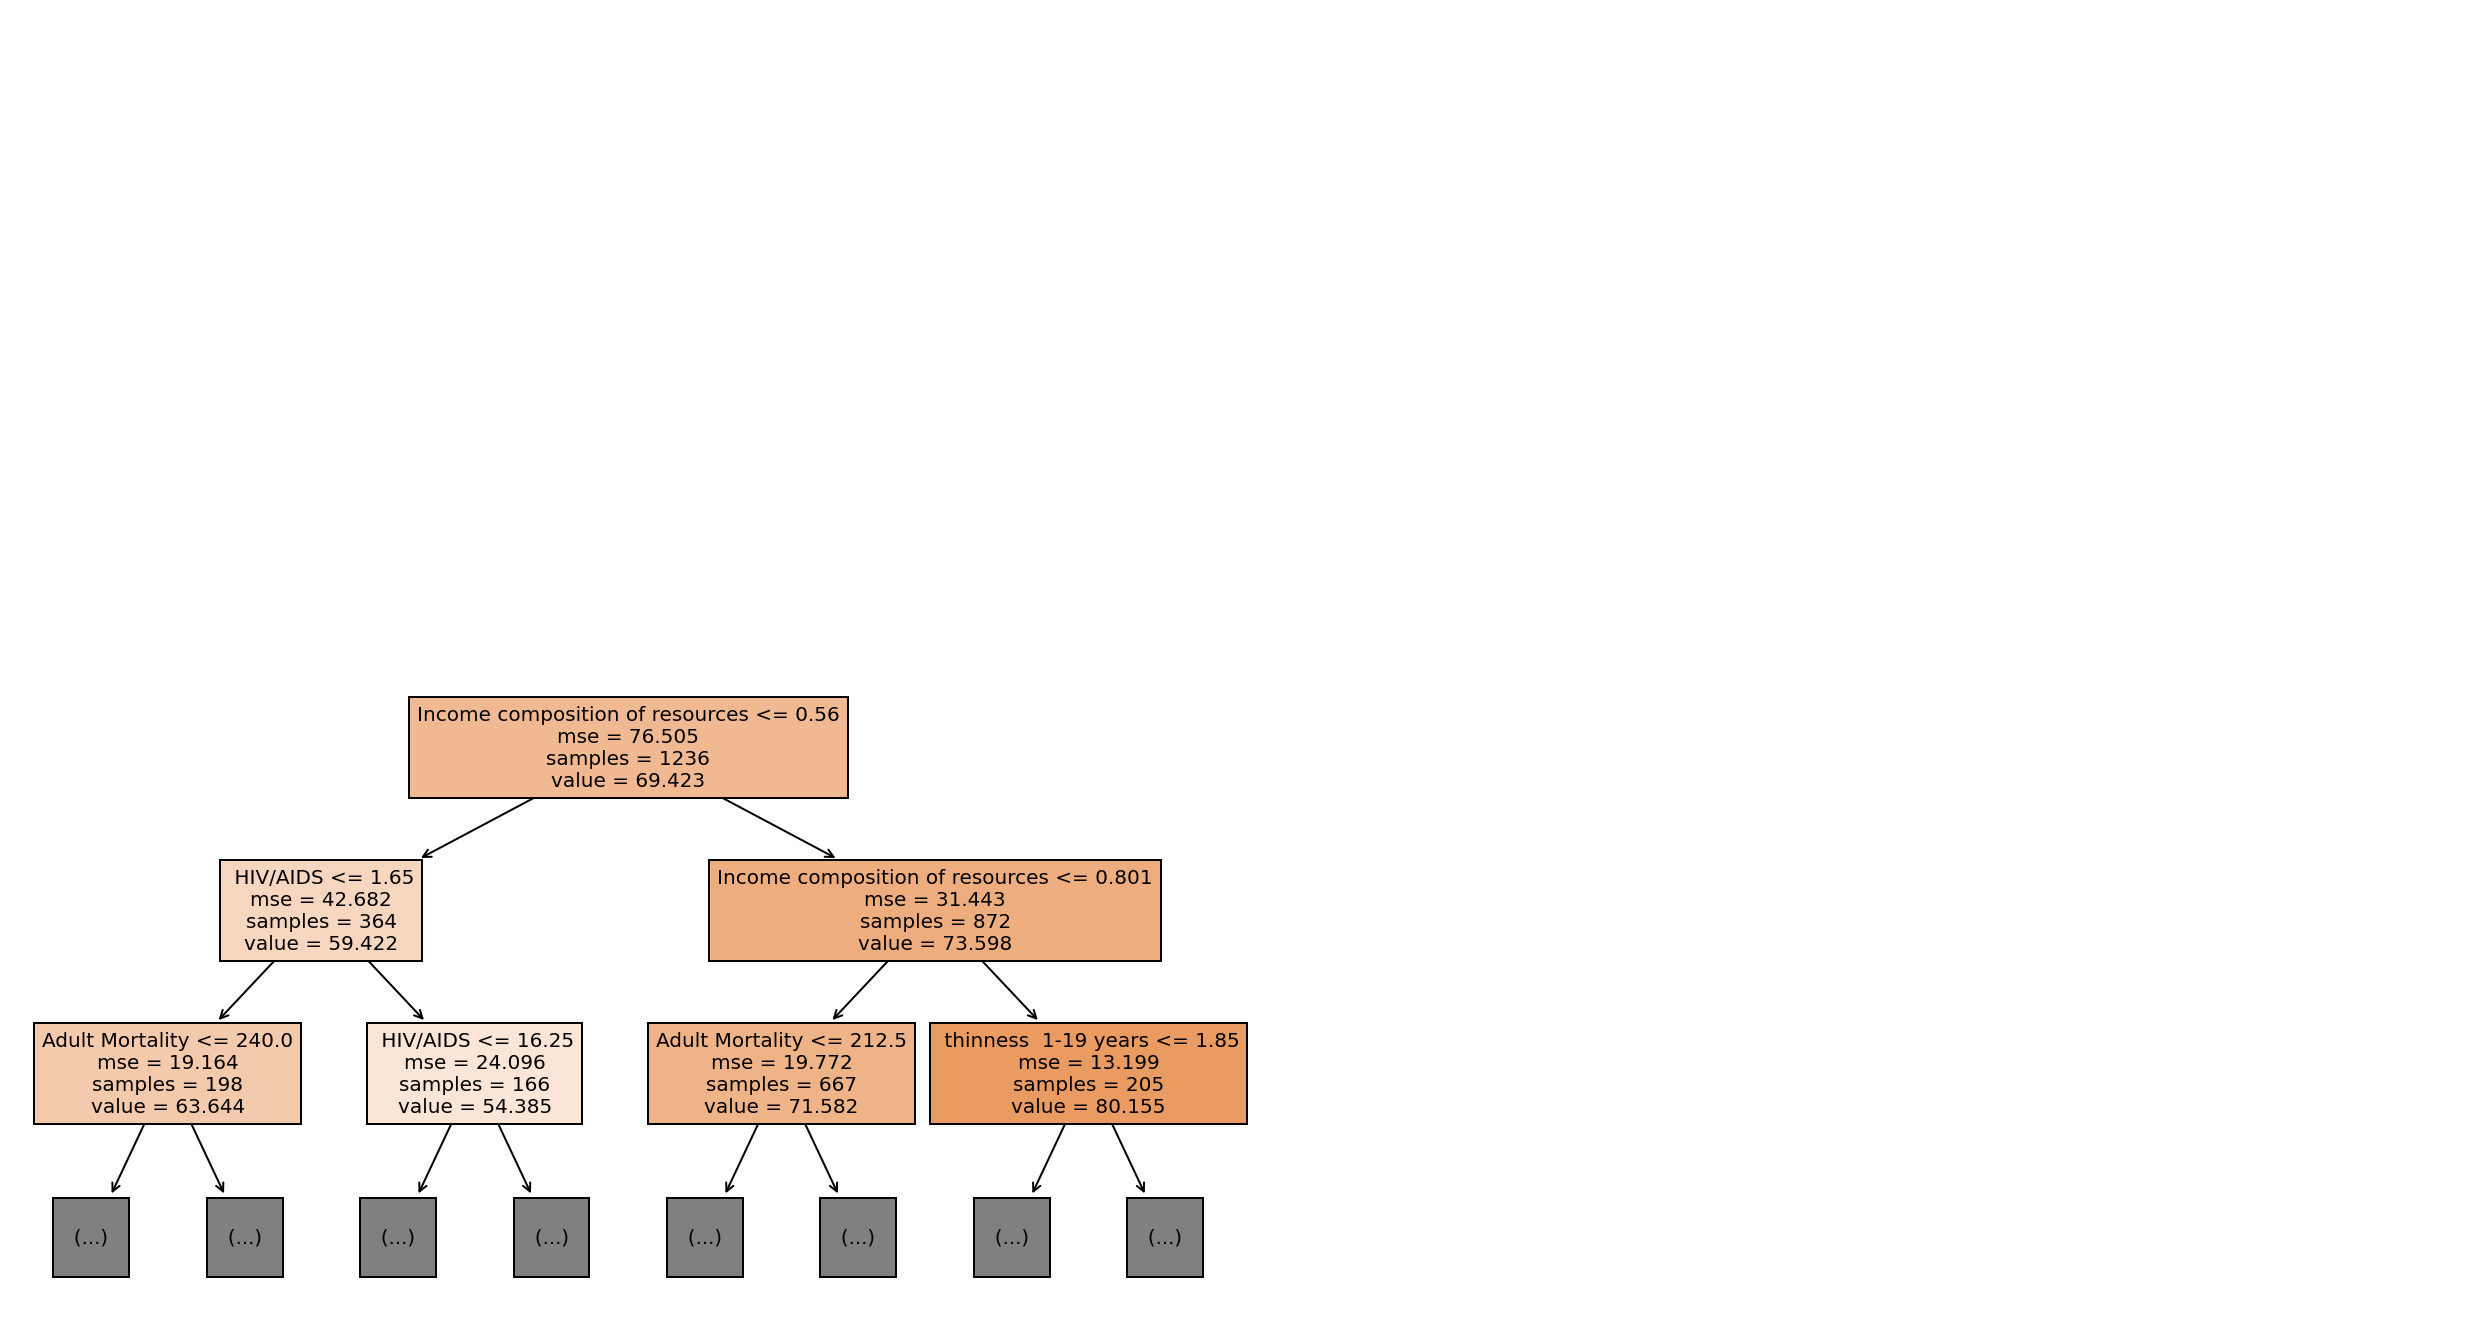

In [12]:
## 결정트리 그리기

plt.figure(figsize=(22,12))

tree.plot_tree(dtr, fontsize=10,
              feature_names=X.columns,
              filled=True,
              impurity=True,
              max_depth=2)
plt.show()

depth:  28 , R-squared:  0.955


<AxesSubplot:xlabel='depth'>

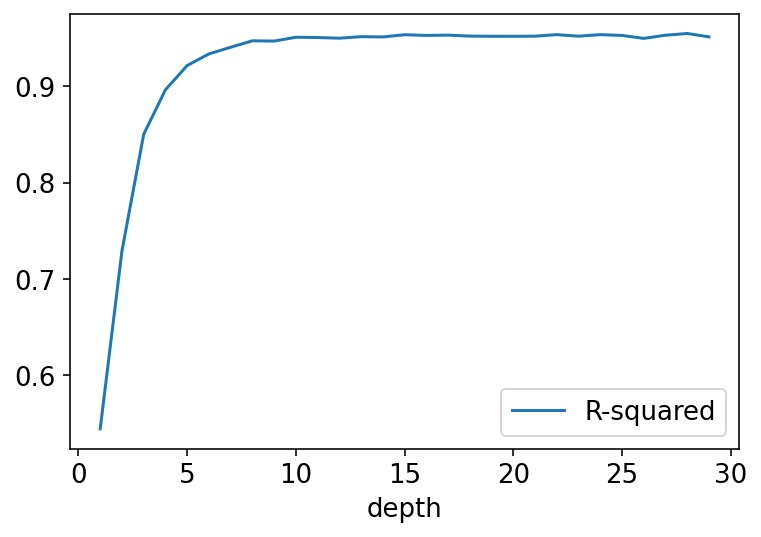

In [13]:
## 랜덤 포레스트를 이용한 회귀 예측

# 최적의 트리 깊이 (max_depth)를 실험으로 찾는다
res = []
for depth in range(1,30):
    rfr = RandomForestRegressor(max_depth=depth) 
    rfr.fit(X_train, y_train) 
    res.append((depth, rfr.score(X_test, y_test).round(4))) 

df_res = pd.DataFrame(res, columns=['depth','R-squared']).set_index('depth')
print('depth: ',df_res.idxmax()[0], ', R-squared: ',df_res.max()[0])
df_res.plot()

Max Error:  9.124
Mean Absolute Error:  1.248
Root Mean Squared Error:  1.968
R-Squared:  0.951


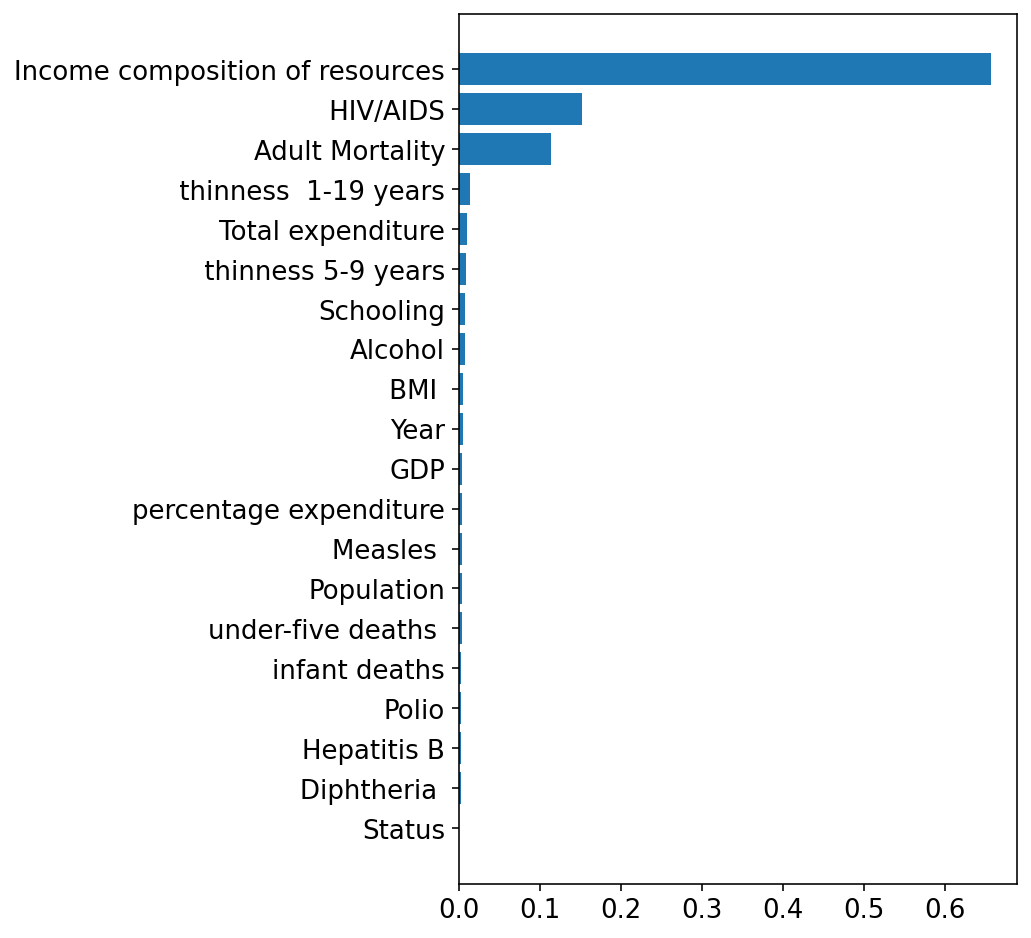

In [14]:
## 랜덤 포레스트 모델 성능 확인

rfr = RandomForestRegressor(max_depth=13)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
show_reg_result(y_test,y_pred)

plot_feature_weight(X.columns, rfr.feature_importances_)

## 부스팅 (LightGBM)

- 설치가 안되어 있는 경우 아래와 같이 설치해야 함
- !conda install lightgbm -y

depth:  19 , R-squared:  0.952


<AxesSubplot:xlabel='depth'>

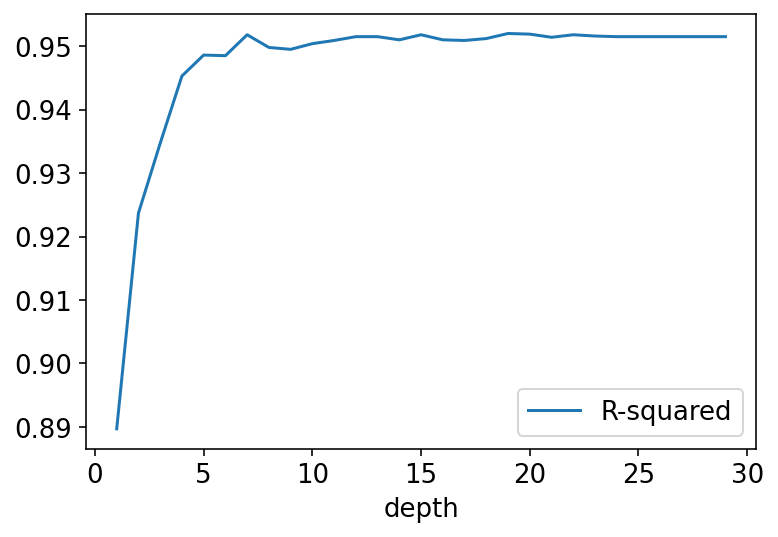

In [15]:
## LightGBM 부스팅 모델을 이용한 회귀 예측

# 최적의 트리 깊이 (max_depth)를 실험으로 찾는다
res = []
for depth in range(1,30):
    lgbm_r = LGBMRegressor(max_depth=depth, num_leaves=32) 
    lgbm_r.fit(X_train, y_train, eval_set=(X_test, y_test), 
           early_stopping_rounds=5, verbose=False)
    res.append((depth, lgbm_r.score(X_test, y_test).round(4))) 

df_res = pd.DataFrame(res, columns=['depth','R-squared']).set_index('depth')
print('depth: ',df_res.idxmax()[0], ', R-squared: ',df_res.max()[0])
df_res.plot()

Max Error:  12.862
Mean Absolute Error:  1.221
Root Mean Squared Error:  1.955
R-Squared:  0.952


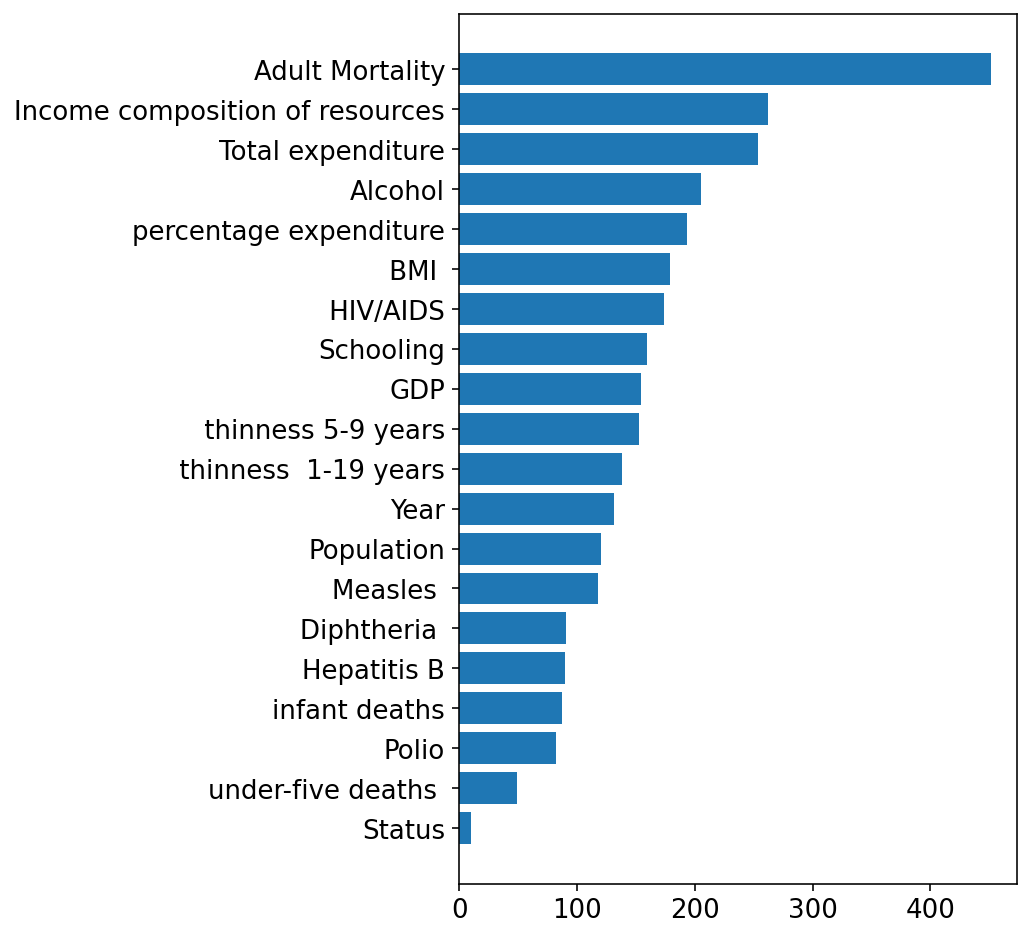

In [16]:
## 부스팅 모델 성능 확인

lgbm_r = LGBMRegressor(max_depth=19, num_leaves=32)
lgbm_r.fit(X_train, y_train, eval_set=(X_test, y_test), 
           early_stopping_rounds=5, verbose=False)
y_pred = lgbm_r.predict(X_test)
show_reg_result(y_test,y_pred)

plot_feature_weight(X.columns, lgbm_r.feature_importances_)

In [17]:
y_test

2444    74.5
1896    52.7
194     71.0
456     72.3
2584    71.1
        ... 
550     79.3
97      74.6
406     56.9
358     73.6
2065    77.7
Name: Life expectancy , Length: 413, dtype: float64

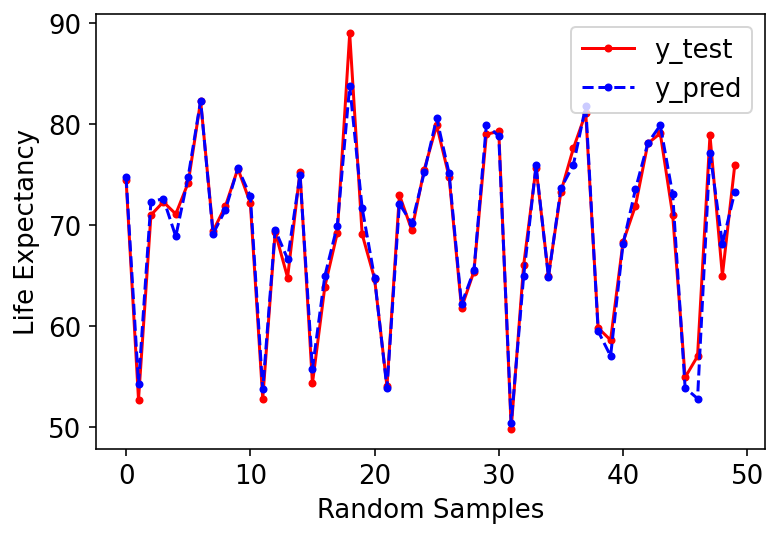

In [18]:
## 회귀 예측과 실제값 샘플 비교하기

def plot_reg_result(y_test, y_pred, N=50):
    y_test = y_test.values
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.xlabel("Random Samples")
    plt.ylabel("Life Expectancy")
    plt.show()

y_pred = lgbm_r.predict(X_test)
plot_reg_result(y_test, y_pred)

In [31]:
error_idx = X_test[np.abs(y_test - y_pred) > 30].index
df.loc[error_idx]

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
503,Canada,2008,0,87.0,74.0,2,8.30,8433.936814,28.0,62,...,89.0,1.30,92.0,0.1,46596.335990,33245773.0,0.5,0.4,0.897,15.8
1274,Israel,2007,0,84.0,68.0,1,2.33,4.345102,99.0,539,...,95.0,7.37,95.0,0.1,258.637000,7181.0,1.1,1.1,0.872,15.7
1486,Lesotho,2003,0,45.5,648.0,5,1.99,5.300902,17.0,1,...,9.0,7.13,9.0,33.8,63.636279,191897.0,1.2,1.1,0.440,10.5
1029,Greece,2012,0,84.0,76.0,0,8.20,2528.992935,98.0,3,...,99.0,9.24,99.0,0.1,22242.681930,114511.0,0.8,0.7,0.858,16.8
997,Germany,2012,1,86.0,71.0,2,11.18,839.913320,88.0,166,...,94.0,1.99,95.0,0.1,4465.248910,8425823.0,1.1,1.1,0.916,16.9


## (참고) 오분류된 샘플 찾기

- 0(개발도상국)을 1(개발국)으로 잘 못 분류한 경우

In [19]:
index_false = X_test[y_test < y_pred].index
print(index_false.size)
df.loc[index_false]

245


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2444,Sri Lanka,2012,0,74.5,143.0,3,2.80,20.768773,99.0,51,...,99.0,3.21,99.0,0.1,335.521375,2425.0,15.3,15.2,0.752,13.7
1896,Nigeria,2012,0,52.7,374.0,505,8.54,204.718626,42.0,6447,...,42.0,3.30,42.0,4.4,2755.297787,167297284.0,1.7,1.6,0.507,9.7
194,Bangladesh,2013,0,71.0,135.0,104,0.01,52.829865,96.0,237,...,96.0,2.88,96.0,0.1,951.889453,157571292.0,18.3,18.8,0.565,10.0
456,Cabo Verde,2007,0,72.3,126.0,0,5.28,345.463714,96.0,0,...,98.0,4.30,98.0,0.6,3112.285712,486438.0,8.1,8.0,0.602,11.9
2053,Poland,2001,1,74.2,149.0,3,7.74,466.738311,95.0,133,...,98.0,5.86,98.0,0.1,4981.198619,3824876.0,2.5,2.7,0.784,14.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,Belgium,2012,1,83.0,78.0,0,10.08,664.473898,98.0,109,...,99.0,1.54,99.0,0.1,4474.571700,11128246.0,0.9,0.9,0.886,16.2
339,Botswana,2012,0,63.4,3.0,2,0.01,12.834474,95.0,7,...,96.0,6.27,95.0,4.4,729.231453,289315.0,7.3,7.0,0.687,12.5
780,Dominican Republic,2005,0,69.7,28.0,7,5.71,289.741865,87.0,0,...,86.0,4.26,87.0,2.0,3681.599300,9237566.0,3.5,3.4,0.668,12.6
406,Burkina Faso,2009,0,56.9,283.0,44,4.55,81.143047,92.0,54118,...,91.0,7.41,92.0,1.1,552.745552,1514199.0,9.3,8.8,0.356,5.9


## (참고) 가장 성능이 좋은 3개의 특성 선택하기
- 임의로 3개의 특성을 선택했을 때 성능이 가능 좋은 경우가 언제인지 찾아보시오
- 선형모델 가중치가 큰 특성 고르기, 상관계수가 큰 특성 고르기, 특성중요도가 큰 특성 고르기를 각각 3개씩 선택하고 성능을 비교하시오
- 결정트리, 랜덤 포레스트, 부스팅 모델의 성능을 각각 구하시오 (총 9가지 경우의 성능 비교)

In [20]:
X.columns

Index([' BMI ', ' HIV/AIDS', ' thinness  1-19 years', ' thinness 5-9 years',
       'Adult Mortality', 'Alcohol', 'Diphtheria ', 'GDP', 'Hepatitis B',
       'Income composition of resources', 'Measles ', 'Polio', 'Population',
       'Schooling', 'Status', 'Total expenditure', 'Year', 'infant deaths',
       'percentage expenditure', 'under-five deaths '],
      dtype='object')

In [35]:
mat = df.corr()
abs(mat).sort_values(ascending=False, by = 'Life expectancy ')

,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Life expectancy,0.050771,0.442798,1.000000,0.702523,0.169074,0.402718,0.409631,0.199935,0.068881,0.542042,...,0.327294,0.174718,0.341331,0.592236,0.441322,0.022305,0.457838,0.457508,0.721083,0.727630
Schooling,0.088732,0.512543,0.727630,0.421171,0.214372,0.616975,0.422088,0.215182,0.115660,0.554844,...,0.350147,0.243783,0.350398,0.211840,0.467947,0.040312,0.491199,0.472482,0.784741,1.000000
Income composition of resources,0.122892,0.463615,0.721083,0.442203,0.134754,0.561074,0.402170,0.184921,0.058277,0.510505,...,0.314682,0.183653,0.343262,0.248590,0.446856,0.008132,0.453679,0.438484,1.000000,0.784741
Adult Mortality,0.037092,0.278173,0.702523,1.000000,0.042450,0.175535,0.237610,0.105225,0.003967,0.351542,...,0.199853,0.085227,0.191429,0.550691,0.255035,0.015012,0.272230,0.286723,0.442203,0.421171
HIV/AIDS,0.123405,0.129555,0.592236,0.550691,0.007712,0.027113,0.095085,0.094802,0.003522,0.210897,...,0.107885,0.043101,0.117601,1.000000,0.108081,0.027801,0.172592,0.183147,0.248590,0.211840
BMI,0.005739,0.298380,0.542042,0.351542,0.234425,0.353396,0.242738,0.143302,0.153245,1.000000,...,0.186268,0.189469,0.176295,0.210897,0.266114,0.081416,0.547018,0.554094,0.510505,0.554844
thinness 1-19 years,0.019757,0.308005,0.457838,0.272230,0.463415,0.403755,0.255035,0.129406,0.180642,0.547018,...,0.164070,0.209872,0.187242,0.172592,0.277498,0.282529,1.000000,0.927913,0.453679,0.491199
thinness 5-9 years,0.014122,0.307279,0.457508,0.286723,0.461908,0.386208,0.255635,0.133251,0.174946,0.554094,...,0.174489,0.217865,0.180952,0.183147,0.277959,0.277913,0.927913,1.000000,0.438484,0.472482
Status,0.034138,1.000000,0.442798,0.278173,0.108757,0.607782,0.461688,0.140351,0.071963,0.298380,...,0.201917,0.192538,0.201654,0.129555,0.484801,0.034790,0.308005,0.307279,0.463615,0.512543
GDP,0.096421,0.484801,0.441322,0.255035,0.098092,0.443433,0.959299,0.041850,0.064768,0.266114,...,0.156809,0.180373,0.158438,0.108081,1.000000,0.020369,0.277498,0.277959,0.446856,0.467947


In [21]:
# 세가지 경우에 대해서(선형계수, 상관계수, 특성중요도) 값이 큰 순으로 특성을 3개씩 선택했다.
feature_linear = ['infant deaths','under-five deaths ','Schooling']
feature_corr = ['Schooling','Income composition of resources', 'Adult Mortality']
feature_rfr = ['Income composition of resources',' HIV/AIDS', 'Adult Mortality']

for feature in [feature_linear, feature_corr, feature_rfr]:
    X_ft = X[feature]
    print(feature)
    X_train, X_test, y_train, y_test = train_test_split(X_ft, y)
    dtr.fit(X_train, y_train)
    print("DecisionTree Model:", dtr.score(X_test, y_test).round(3))
    rfr.fit(X_train, y_train)
    print("Random Forest Model:", rfr.score(X_test, y_test).round(3))
    lgbm_r.fit(X_train, y_train)
    print("Light GBM Model:", lgbm_r.score(X_test, y_test).round(3))
    print()

['infant deaths', 'under-five deaths ', 'Schooling']
DecisionTree Model: 0.606
Random Forest Model: 0.768
Light GBM Model: 0.733

['Schooling', 'Income composition of resources', 'Adult Mortality']
DecisionTree Model: 0.909
Random Forest Model: 0.935
Light GBM Model: 0.922

['Income composition of resources', ' HIV/AIDS', 'Adult Mortality']
DecisionTree Model: 0.921
Random Forest Model: 0.943
Light GBM Model: 0.936



In [37]:
# PCA
import pca